# Imports

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from IPython import get_ipython
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup plots

In [5]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

get_ipython().config.InlineBackend.figure_format = 'retina'

# Some functions to convert values in column between numbers and strings

In [6]:
dictionaries = {}
def convert_to_digits(df, col):
    uniques = df[col].unique()
    #index = df.index
    unique_names = {}
    digits = []
    i = 0
    for uniq in uniques:
        unique_names[uniq] = i
        i = i + 1
    for name in tqdm(df[col]):
        digits = digits + [unique_names[name]]
    dictionaries[col] = unique_names
    return digits

def get_key(d, value):
    return [key for key, val in d.items() if val==value]
    
def convert_back(df, col):
    unique_names = dictionaries[col]
    names = []
    for digit in tqdm(df[col]):
        names = names + get_key(unique_names, digit)
    return names

# Reading needed files with data

In [7]:
holidays_events = pd.read_csv(
    './store-sales-time-series-forecasting/holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

In [8]:
stores = pd.read_csv(
    './store-sales-time-series-forecasting/stores.csv',
    dtype={
        'store_nbr': 'category',
        'city': 'category',
        'state': 'category',
        'type': 'category',
        'cluster': 'category',
    },
    index_col = 'store_nbr',
)

In [9]:
stores['city'] = convert_to_digits(stores, col='city')
stores['state'] = convert_to_digits(stores, col='state')
stores['type'] = convert_to_digits(stores, col='type')

100%|██████████| 54/54 [00:00<00:00, 6245.14it/s]


In [10]:
transactions = pd.read_csv(
    './store-sales-time-series-forecasting/transactions.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
)
transactions = transactions.set_index('date').to_period('D')

In [11]:
oil = pd.read_csv(
    './store-sales-time-series-forecasting/oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
)
oil = oil.set_index('date').to_period('D')

In [12]:
store_sales = pd.read_csv(
    './store-sales-time-series-forecasting/train.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales = store_sales.join(oil.fillna(method='bfill'), on='date')
store_sales = store_sales.join(stores, on='store_nbr')
#store_sales = pd.merge(store_sales, transactions, on=['store_nbr', 'date'], how='outer')
store_sales['dcoilwtico'] = store_sales['dcoilwtico'].fillna(method='bfill')

# Creating model for Store Sales - Time Series Forecasting competition

### Creating a seasonal model for the full Store Sales dataframe

In [13]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [15]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
#y_deseason = y - y_pred
#y_deseason.name = 'family_sales_deseasoned'

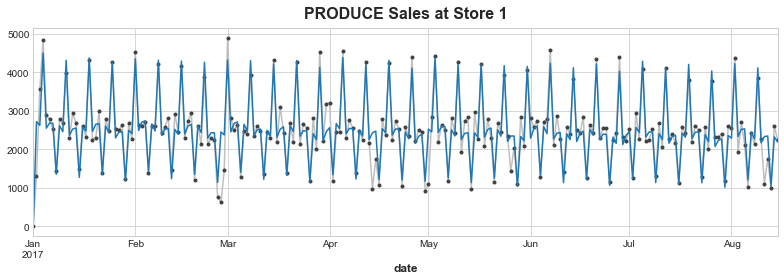

In [16]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

### Loading test data and check the efficincy of our model on it

In [17]:
df_test = pd.read_csv(
    './store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

#X_holidays_test = pd.get_dummies(holidays_test)

#X_test = X_test.join(X_holidays_test, on='date').fillna(0.0)

y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])

In [ ]:
#y_submit = y_submit.drop(columns=['city','cluster','dcoilwtico','onpromotion','state','type'])
#y_submit.to_csv('submission.csv', index=False)